<a href="https://colab.research.google.com/github/dabodobo/Sistemas-Inteligentes/blob/main/Image_Classifier_Keras_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building an Image Classifier with Keras and TensorFlow

Keras is a high-level Deep Learning API that allows you to easily build, train, evaluate and execute all sorts of neural networks. Its documentation (or specification) is available at [https://keras.io](https://keras.io).

To perform the heavy computations required by neural networks, Keras relies on a computation backend. At the present, you can choose from three popular open
source deep learning libraries: [TensorFlow](https://www.tensorflow.org/), [Microsoft Cognitive Toolkit (CNTK)](https://learn.microsoft.com/en-us/cognitive-toolkit/) or [Theano](https://github.com/Theano/).

Moreover, TensorFlow itself now comes bundled with its own Keras
implementation called tf.keras. It only supports TensorFlow as the backend, but it has the advantage of offering some very useful extra features: for
example, it supports TensorFlow’s Data API which makes it quite easy to load and
preprocess data efficiently.

First let's import TensorFlow and Keras.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

To plot pretty figures:


In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


The training set contains 60,000 grayscale images, each 28x28 pixels:

In [4]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [5]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [6]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

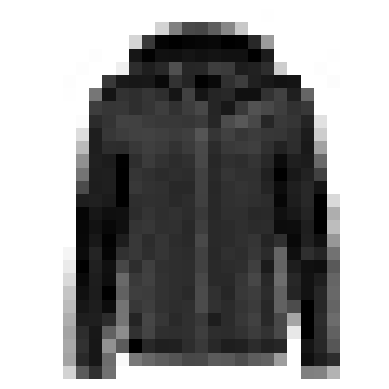

In [7]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [8]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [9]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [10]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [11]:
X_valid.shape

(5000, 28, 28)

In [12]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

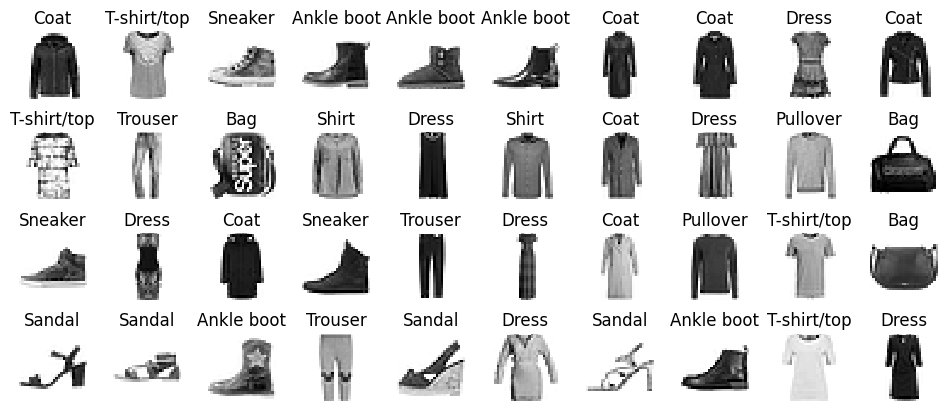

In [13]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Creating the model using the Sequential API

Now let's build the neural network! Here is a classification MLP with two hidden layers:

In [14]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Let’s go through this code line by line:
* The first line creates a `Sequential` model. This is the simplest kind of Keras model, for neural networks that are just composed of a single stack of layers, connected sequentially. This is called the sequential API.
* Next, we build the first layer and add it to the model. It is a `Flatten` layer whose role is simply to convert each input image into a 1D array: if it receives input data `X` , it computes `X.reshape(-1, 1)` . This layer does not have any parameters, it is just there to do some simple preprocessing. Since it is the first layer in the model, you should specify the `input_shape` : this does not include the batch size, only the shape of the instances. Alternatively, you could add a `keras.layers.InputLayer` as the first layer, setting `shape=[28,28]` .
* Next we add a `Dense` hidden layer with 300 neurons. It will use the ReLU activation function. Each `Dense` layer manages its own weight matrix, containing all the connection weights between the neurons and their inputs. It also manages a vector of bias terms (one per neuron).
* Next we add a second `Dense` hidden layer with 100 neurons, also using the ReLU activation function.
* Finally, we add a `Dense` output layer with 10 neurons (one per class), using the softmax activation function (because the classes are exclusive).

Instead of adding the layers one by one as we just did, you can pass a list of layers when creating the `Sequential` model:

In [15]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

The model’s `summary()` method displays all the model’s layers, including each layer’s name (which is automatically generated unless you set it when creating the layer), its output shape (`None` means the batch size can be anything), and its number of parameters. The summary ends with the total number of parameters, including trainable and non-trainable parameters. Here we only have trainable parameters:

In [16]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

13 You can also generate an image of your model using `keras.utils.plot_model()`:

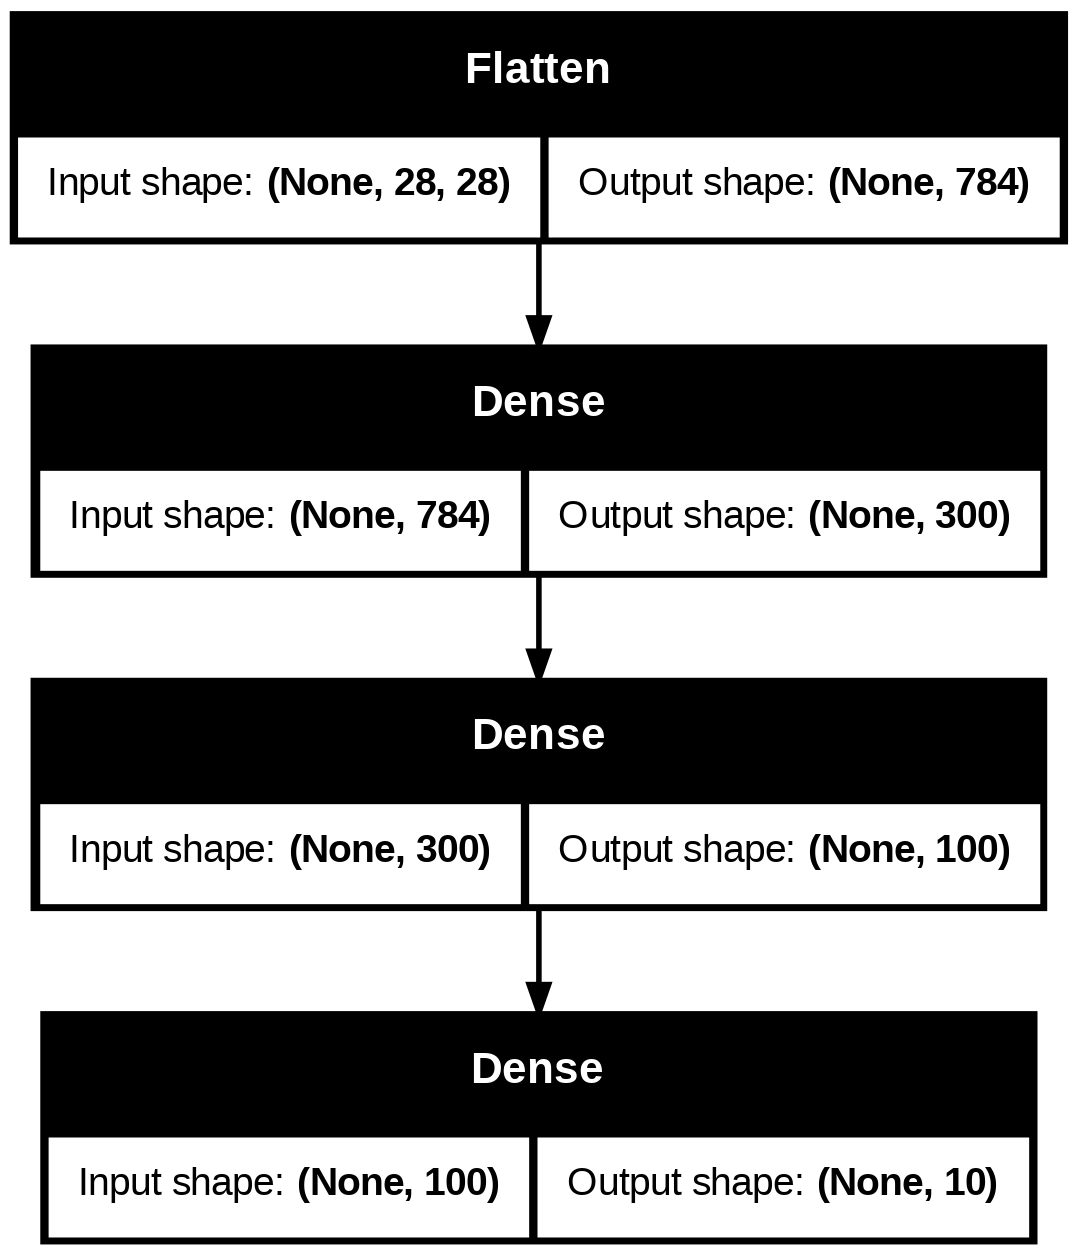

In [17]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

All the parameters of a layer can be accessed using its `get_weights()` and
`set_weights()` method. For a Dense layer, this includes both the connection weights and the bias terms:

In [18]:
hidden1 = model.layers[1]
weights, biases = hidden1.get_weights()

In [19]:
weights

array([[ 0.04871123,  0.04671659,  0.01940103, ..., -0.07143921,
        -0.04611135, -0.01763003],
       [ 0.01279619, -0.03851259,  0.02751118, ..., -0.02159199,
         0.00031536,  0.00544415],
       [-0.0067471 ,  0.05193289, -0.06736234, ...,  0.06088315,
         0.01486565, -0.01522695],
       ...,
       [-0.00088113,  0.0310684 , -0.03535504, ..., -0.05985884,
         0.07042672,  0.06920128],
       [ 0.01667167,  0.00284985, -0.03318671, ...,  0.01752138,
        -0.06840761,  0.02753264],
       [ 0.06471391,  0.04049004,  0.04565749, ...,  0.05465618,
         0.00987224,  0.0372038 ]], dtype=float32)

In [20]:
weights.shape

(784, 300)

In [21]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [22]:
biases.shape

(300,)

Notice that the Dense layer initialized the connection weights randomly (which is needed to break symmetry), and the biases were just initialized to zeros, which is fine. If you ever want to use a different initialization method,
you can set `kernel_initializer` (*kernel* is another name for the matrix of connection weights) or `bias_initializer` when creating the layer.

## Compiling the model

After a model is created, you must call its `compile()` method to specify the loss function and the optimizer to use. Optionally, you can also specify a list of extra metrics to compute during training and evaluation:

In [23]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

## Training and Evaluating the Model

Now the model is ready to be trained. For this we simply need to call its `fit()` method. We pass it the input features (`X_train`) and the target classes (`y_train`), as well as the number of epochs to train (or else it would default to just 1, which would definitely not be enough to converge to a good solution). We also pass a validation set (this is optional): Keras will measure the loss and the extra metrics on this set at the end of each epoch, which is very useful to see how well the model really performs: if the performance on the training set is much better than on the validation set, your model is probably overfitting the training set (or there is a bug, such as a data mismatch between the training set and the validation set):

In [24]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6769 - loss: 1.0191 - val_accuracy: 0.8260 - val_loss: 0.5186
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8233 - loss: 0.5075 - val_accuracy: 0.8486 - val_loss: 0.4478
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8427 - loss: 0.4478 - val_accuracy: 0.8606 - val_loss: 0.4142
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8541 - loss: 0.4140 - val_accuracy: 0.8670 - val_loss: 0.3877
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8599 - loss: 0.3918 - val_accuracy: 0.8682 - val_loss: 0.3837
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8642 - loss: 0.3857 - val_accuracy: 0.8684 - val_loss: 0.3792
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8670 - loss: 0.3746 - val_accuracy: 0.8740 - val_loss: 0.3569
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8696 - loss: 0.3646 -

And that’s it! The neural network is trained. At each epoch during training, Keras displays the number of instances processed so far (along with a progress bar), the mean training time per sample, the loss and accuracy (or any other extra metrics you asked for), both on the training set and the validation set. You can see that the training loss went down, which is a good sign, and the validation accuracy reached 87.28% after 30 epochs, not too far from the training accuracy, so there does not seem to be much overfitting going on.

The `fit()` method returns a History object containing the training parameters (`history.params`), the list of epochs it went through (`history.epoch`), and most importantly a dictionary (`history.history`) containing the loss and extra metrics it measured at the end of each epoch on the training set and on the validation set (if any). If you create a Pandas DataFrame using this dictionary and call its `plot()` method, you get the learning curves:

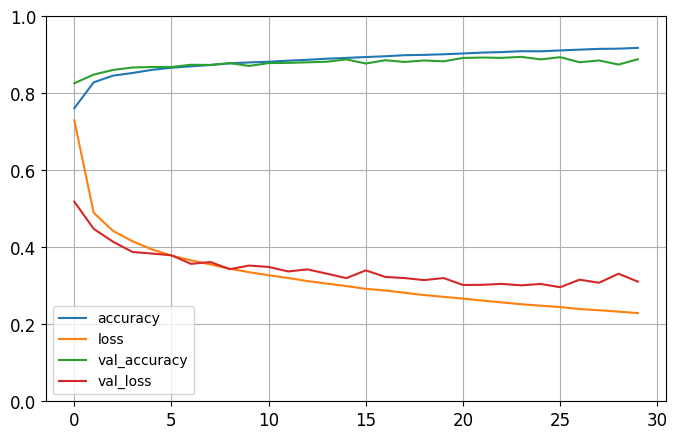

In [25]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

You can see that both the training and validation accuracy steadily increase during training, while the training and validation loss decrease. Good! Moreover, the validation curves are quite close to the training curves, which means that there is not too much overfitting. In this particular case, the model performed better on the validation set than on the training set at the beginning of training: this sometimes happens by chance (especially when the validation set is fairly small). However, the training set performance ends up beating the validation performance, as is generally the case when you train for long enough. You can tell that the model has not quite converged yet, as the validation loss is still going down, so you should probably continue training. It’s as simple as calling the fit() method again, since Keras just continues training where it left off (you should be able to reach close to 89% validation accuracy).

If you are not satisfied with the performance of your model, you should go back and tune the model’s hyperparameters, for example the number of layers, the number of neurons per layer, the types of activation functions we use for each hidden layer, the number of training epochs, the batch size (it can be set in the `fit()` method using the `batch_size` argument, which defaults to 32). Once you are satisfied with your model’s validation accuracy, you should evaluate it on the test set to estimate the generalization error before you deploy the model to production. You can easily do this using the `evaluate()` method (it also supports several other arguments, such as `batch_size` or `sample_weight`, please check the documentation for more details):

In [27]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8761 - loss: 0.3501


[0.3476441502571106, 0.8773000240325928]

It is common to get slightly lower performance on the test set
than on the validation set, because the hyperparameters are tuned on the validation set, not the test set (however, in this example, we did not do any hyperparameter tuning, so the lower accuracy is just bad luck). Remember to resist the temptation to tweak the hyperparameters on the test set, or else your estimate of the generalization error will be too optimistic.

## Using the Model to Make Predictions

Next, we can use the model’s `predict()` method to make predictions on new instances. Since we don’t have actual new instances, we will just use the first 3 instances of the test set:

In [32]:
X_new = X_test[:9]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.99],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.23, 0.  , 0.05, 0.  , 0.01, 0.  , 0.71, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.  , 0.98, 0.  , 0.01, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

As you can see, for each instance the model estimates one probability per class, from class 0 to class 9. If you only care about the class with the highest estimated probability (even if that probability is quite low) then you can use `np.argmax(model.predict(X_new), axis=-1)`:

In [33]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


array([9, 2, 1, 1, 6, 1, 4, 6, 5])

In [34]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt', 'Trouser',
       'Coat', 'Shirt', 'Sandal'], dtype='<U11')

And the classifier actually classified all three images correctly:

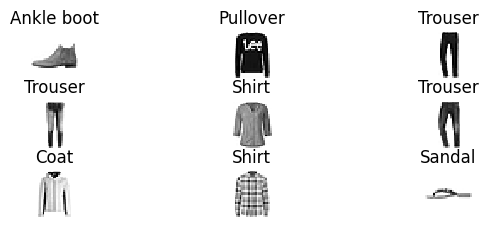

In [36]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(3, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Now you know how to build, train, evaluate and use a classification MLP using the Sequential API. Congratulations!